# Background Subtraction Method

In [63]:
from expt_utils import *
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

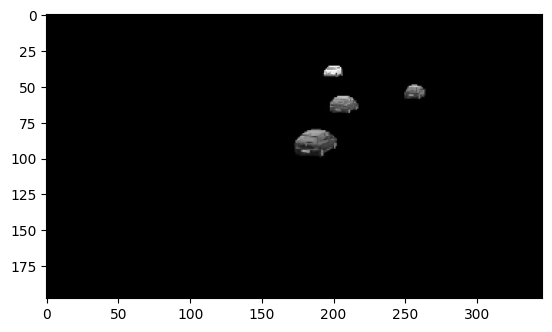

In [98]:
img_ground_truth = cv.imread('../experiments/img/00025_8880-5.jpg')
img_ground_truth = cv.cvtColor(img_ground_truth, cv.COLOR_BGR2GRAY)
img_ground_truth= cv.resize(img_ground_truth, (int(img_ground_truth.shape[1] * 0.4), int(img_ground_truth.shape[0] * 0.4)))
background_dir = '../dataset/frames/test/video25'

imgs = []

for filename in os.listdir(background_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(background_dir, filename)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        imgs.append(img)

frames_stack = np.stack(imgs, axis=-1)

background_median = np.median(frames_stack, axis=-1).astype(np.uint8)
background_median = cv.resize(background_median, (int(background_median.shape[1] * 0.4), int(background_median.shape[0] * 0.4)))

plt.imshow(img_ground_truth, cmap='gray')

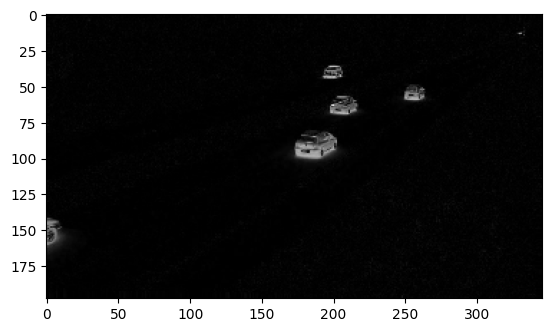

In [99]:
foreground_images = []

save_dir = 'D:\\accounts'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

idx = 1
for filename in os.listdir(background_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(background_dir, filename)
        frame = cv.imread(img_path)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frame = cv.resize(frame, (int(frame.shape[1] * 0.4), int(frame.shape[0] * 0.4)))
        foreground = cv.absdiff(frame, background_median)
        foreground_images.append(foreground)
        filename = f'foreground_{idx}.jpg'
        save_path = os.path.join(save_dir, filename)
        cv.imwrite(save_path, foreground)
        idx += 1

# for i, foreground in enumerate(foreground_images):
#     cv.imshow('Foreground Image {}'.format(i), foreground)
#     cv.waitKey(0)

plt.imshow(foreground_images[11], cmap='gray')
cv.destroyAllWindows()

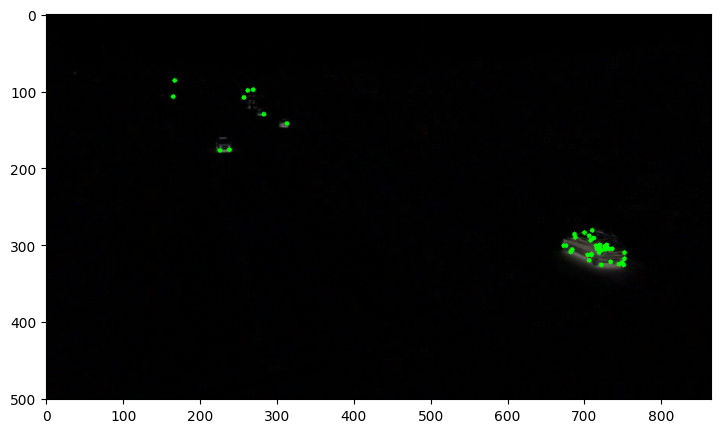

In [ ]:
# bf = cv.BFMatcher()
# orb = cv.SIFT_create()
# img = foreground_images[10]
# dir = '../experiments/img/09'

# img_ground_truths = []

# for filename in os.listdir(dir):
#     if filename.endswith('.jpg') or filename.endswith('.png'):
#         img_path = os.path.join(dir, filename)
#         img_ground_truth = cv.imread(img_path)
#         img_ground_truth = cv.cvtColor(img_ground_truth, cv.COLOR_BGR2RGB)
#         img_ground_truths.append(img_ground_truth)
        

# bf = cv.BFMatcher()
# orb = cv.SIFT_create()

# img = foreground_images[10]

# all_bbox_lists = []
# good_matches = []

# for img_ground_truth in img_ground_truths:
#     keypoints_frame, descriptors_frame = orb.detectAndCompute(img, None)
#     keypoints_grd, descriptors_grd = orb.detectAndCompute(img_ground_truth, None)

#     matches = bf.knnMatch(descriptors_grd, descriptors_frame, k=2)

#     for m, n in matches:
#         if m.distance < 1 * n.distance:
#             good_matches.append(m)
    
#     bbox_list = []
#     for match in good_matches:
#         frame_idx = match.trainIdx
#         frame_pt = keypoints_frame[frame_idx].pt
#         bbox = ((int(frame_pt[0] - 0), int(frame_pt[1] - 0)),
#                 (int(frame_pt[0] + 0), int(frame_pt[1] + 0))) 
#         bbox_list.append(bbox)
    
#     all_bbox_lists.append(bbox_list)

# merged_bbox_list = []
# for bbox_list in all_bbox_lists:
#     merged_bbox_list.extend(bbox_list)

# for bbox in merged_bbox_list:
#     cv.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 5)

# plt.figure(figsize=(20, 5))
# plt.imshow(img)
# plt.show()


# feature detection on resized image

accuracy: 36.08%
Confusion Matrix:
[[82 32]
 [32 25]]
All Truth Keypoints 171
All Estimated Keypoints 158


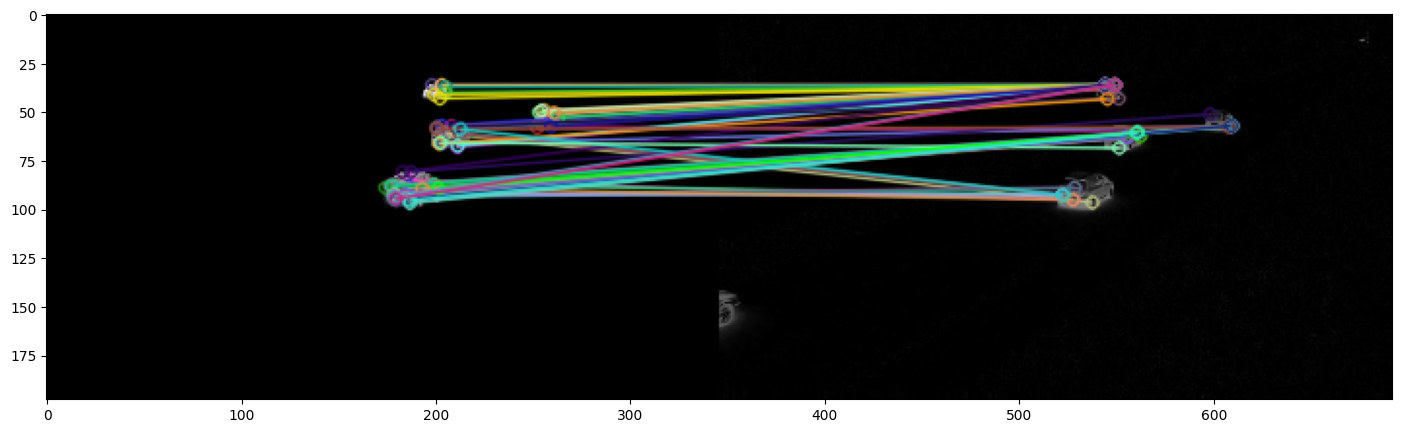

In [100]:
bf = cv.BFMatcher()
orb = cv.ORB_create()
img_subtracted = foreground_images[11]

keypoints_img_ground_truth, descriptors_img_ground_truth = orb.detectAndCompute(img_ground_truth, None)
keypoints_img_subtracted, descriptors_img_subtracted = orb.detectAndCompute(img_subtracted, None)

matches = bf.knnMatch(descriptors_img_ground_truth, descriptors_img_subtracted, k=2)

good_matches = []
total_correct = 0
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)
        total_correct += 1

img_matches = cv.drawMatches(img_ground_truth, keypoints_img_ground_truth, img_subtracted, keypoints_img_subtracted, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_keypoints = total_correct
predicted_keypoints = len(keypoints_img_subtracted)

ground_truth_labels = np.zeros(len(matches))
predicted_labels = np.zeros(len(matches))
for i, match in enumerate(matches):
    if i in [m.queryIdx for m in good_matches]:  # check if the index is in good_matches
        predicted_labels[i] = 1
    if i < len(good_matches):
        ground_truth_labels[i] = 1

conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print(conf_matrix)
print("All Truth Keypoints", len(keypoints_img_ground_truth))
print("All Estimated Keypoints", len(keypoints_img_subtracted))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)

# feature detection on resized & shadow detection image

In [101]:
import cv2 as cv
import numpy as np

def shadow_detection(image_gray):
    image_rgb = cv.cvtColor(image_gray, cv.COLOR_GRAY2RGB)
    lab_image = cv.cvtColor(image_rgb, cv.COLOR_RGB2LAB)

    mean_l = np.mean(lab_image[:, :])
    std_l = np.std(lab_image[:, :])

    shadow_mask = lab_image[:, :] <= (mean_l - std_l/3)

    kernel = np.ones((3, 3), np.uint8)
    cleaned_mask = cv.morphologyEx(shadow_mask.astype(np.uint8), cv.MORPH_OPEN, kernel)
    shadow_mask_cleaned = cv.dilate(cleaned_mask, kernel, iterations=1)
    shadow_mask_cleaned = cv.erode(shadow_mask_cleaned, kernel, iterations=1)

    result_image = np.copy(image_gray)
    result_image[shadow_mask_cleaned] = [0]

    return result_image, shadow_mask_cleaned

def shadow_remove(image_gray, shadow_mask):
    image_float = image_gray.astype(np.float32)

    shadow_pixels = np.where(shadow_mask)
    avg_intensity_inside_shadow = np.mean(image_float[shadow_pixels[0], shadow_pixels[1]])
    outside_shadow_mask = ~shadow_mask
    outside_shadow_pixels = np.where(outside_shadow_mask)
    avg_intensity_outside_shadow = np.mean(image_float[outside_shadow_pixels[0], outside_shadow_pixels[1]])

    constants = avg_intensity_outside_shadow / avg_intensity_inside_shadow

    image_float[shadow_pixels[0], shadow_pixels[1]] *= constants

    result_image = np.clip(image_float, 0, 255).astype(np.uint8)

    return result_image

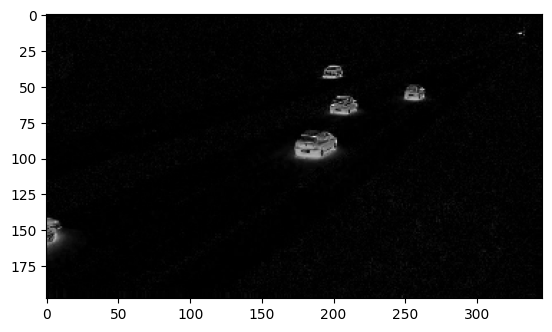

In [102]:
img_subtracted = foreground_images[11]
result_shadow_img, shadow_mask = shadow_detection(img_subtracted)
img_subtracted_shadow_detected = shadow_remove(result_shadow_img,shadow_mask)

plt.imshow(img_subtracted_shadow_detected, cmap='gray')

accuracy: 32.02%
Confusion Matrix:
[[77 37]
 [37 20]]
All Truth Keypoints 171
All Estimated Keypoints 178


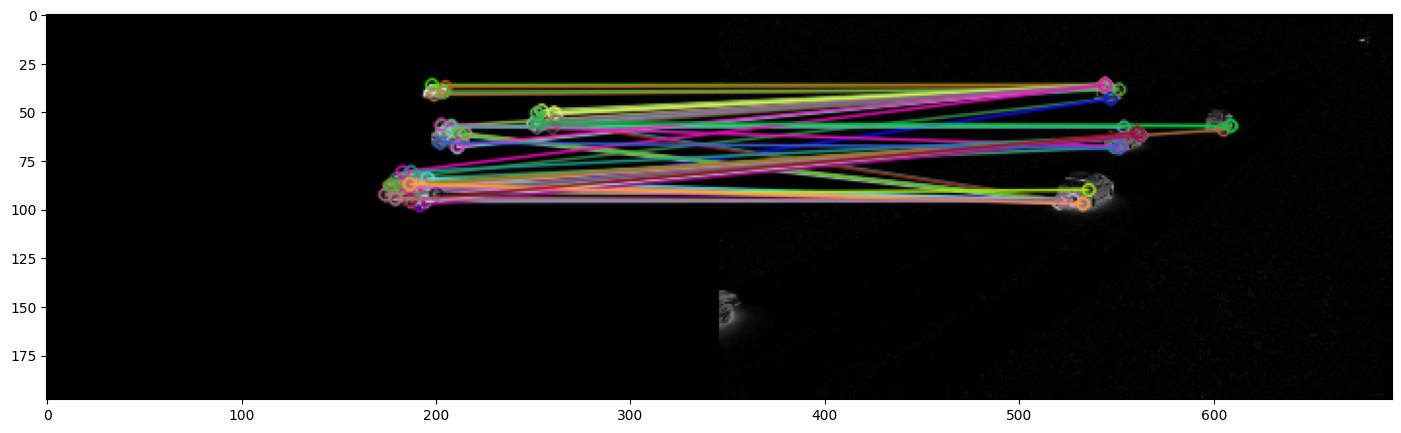

In [103]:
# feature detection
orb = cv.ORB_create()

keypoints_img_ground_truth, descriptors_img_ground_truth = orb.detectAndCompute(img_ground_truth, None)
keypoints_img_subtracted_shadow_detected, descriptors_img_subtracted_shadow_detected = orb.detectAndCompute(img_subtracted_shadow_detected, None)

# object matching
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors_img_ground_truth, descriptors_img_subtracted_shadow_detected, k=2)

good_matches = []
total_correct = 0
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good_matches.append(m)
        total_correct += 1

img_matches = cv.drawMatches(img_ground_truth, keypoints_img_ground_truth, img_subtracted_shadow_detected, keypoints_img_subtracted_shadow_detected, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

ground_truth_keypoints = total_correct
predicted_keypoints = len(keypoints_img_subtracted_shadow_detected)

ground_truth_labels = np.zeros(len(matches))
predicted_labels = np.zeros(len(matches))
for i, match in enumerate(matches):
    if i in [m.queryIdx for m in good_matches]:
        predicted_labels[i] = 1
    if i < len(good_matches):
        ground_truth_labels[i] = 1

conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

print(f"accuracy: {ground_truth_keypoints / predicted_keypoints :.2%}")
print("Confusion Matrix:")
print(conf_matrix)
print("All Truth Keypoints", len(keypoints_img_ground_truth))
print("All Estimated Keypoints", len(keypoints_img_subtracted_shadow_detected))
plt.figure(figsize=(20,5))
plt.imshow(img_matches)

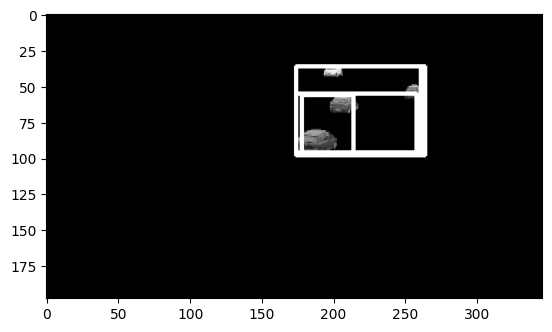

In [104]:
all_descriptors_array = np.array(descriptors_img_ground_truth)

num_objects = 4 
kmeans = KMeans(n_clusters=num_objects)

kmeans.fit(all_descriptors_array)

cluster_labels = kmeans.labels_

clusters = [[] for _ in range(num_objects)]
for i, kp in enumerate(keypoints_img_ground_truth):
    cluster_index = cluster_labels[i]
    clusters[cluster_index].append(kp)

for keypoints in clusters:
    points = np.array([kp.pt for kp in keypoints], dtype=np.int32)
    x, y, w, h = cv.boundingRect(points)
    cv.rectangle(img_ground_truth, (x, y), (x + w, y + h), (255, 255, 255), 2)

plt.imshow(img_ground_truth, cmap='gray')

Object: 1
Object: 1 - Percentage: 93.45794392523365
Object: 3 - Percentage: 3.7383177570093453
Object: 5 - Percentage: 1.8691588785046727
Object: 7 - Percentage: 0.9345794392523363
Object: 2
Object: 3 - Percentage: 80.0
Object: 2 - Percentage: 20.0
Object: 3
Object: 3 - Percentage: 100.0


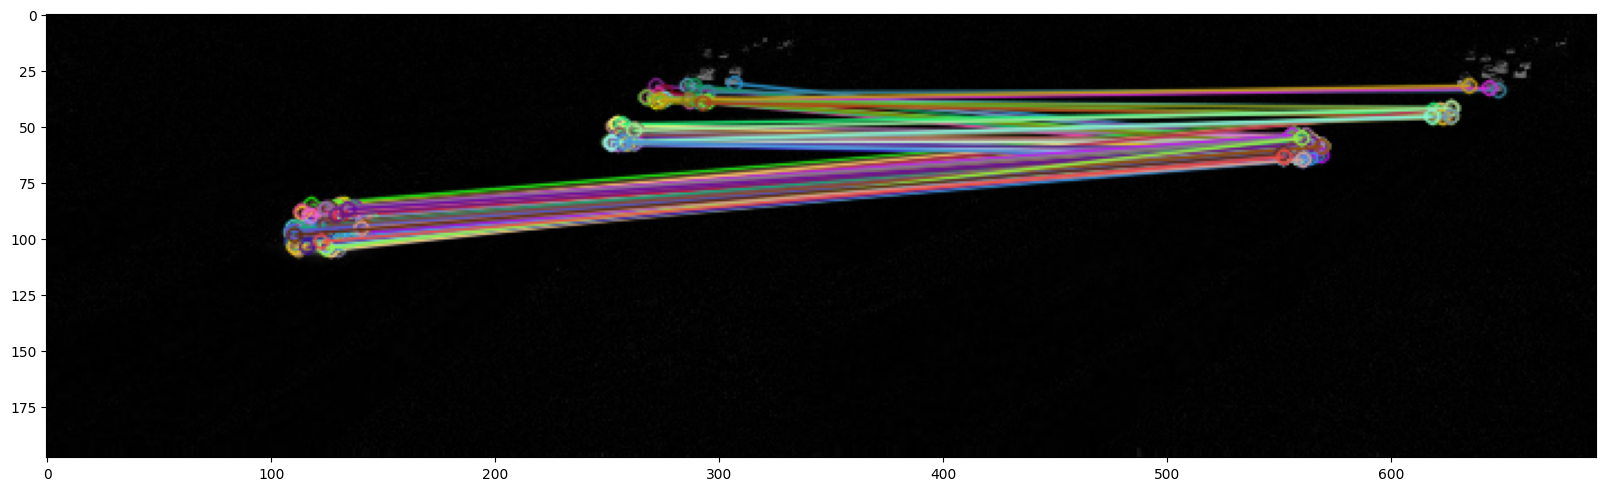

In [106]:
first_img_features = []
first_img_features.append(np.array([274, 211, 96, 57]))
first_img_features.append(np.array([717, 84, 22, 18]))
first_img_features.append(np.array([669, 81, 24, 21]))
first_img_features.append(np.array([627, 125, 34, 25]))
first_img_features.append(np.array([713, 67, 19, 15]))
first_img_features.append(np.array([730, 60, 16, 16]))
first_img_features.append(np.array([759, 68, 17, 13]))

second_img_features = []
second_img_features.append(np.array([514, 135, 49, 32]))
second_img_features.append(np.array([681, 100, 26, 21]))
second_img_features.append(np.array([710, 69, 19, 15]))
second_img_features.append(np.array([743, 71, 19, 17]))
second_img_features.append(np.array([739, 59, 15, 14]))

first = foreground_images[0]
second = foreground_images[1]

orb = cv.ORB_create()

keypoints_img_first, descriptors_img_first = orb.detectAndCompute(first, None)
keypoints_img_second, descriptors_img_second = orb.detectAndCompute(second, None)

# object matching
bf = cv.BFMatcher()

matches = bf.knnMatch(descriptors_img_first, descriptors_img_second, k=2)

good_matches = []
total_correct = 0
first_object_id = []
second_object_id = []

for m, n in matches:
    if m.distance < 1 * n.distance:
        good_matches.append(m)
        total_correct += 1
        
        kp_first_location = keypoints_img_first[m.queryIdx].pt
        kp_second_location = keypoints_img_second[m.trainIdx].pt
        cu_first_id = 0
        cu_second_id = 0
        for i, first_feature in enumerate(first_img_features):
            x = int(first_feature[0] * .4)
            y = int(first_feature[1] * .4)
            w = int(first_feature[2] * .4)
            h = int(first_feature[3] * .4)
            if (x <= kp_first_location[0]) & (x+w >= kp_first_location[0]) & (y <= kp_first_location[1]) & (y+h >= kp_first_location[1]):
                cu_first_id = i+1
                break
        for i, second_feature in enumerate(second_img_features):
            x = int(second_feature[0] * .4)
            y = int(second_feature[1] * .4)
            w = int(second_feature[2] * .4)
            h = int(second_feature[3] * .4)
            if (x <= kp_second_location[0]) & (x+w >= kp_second_location[0]) & (y <= kp_second_location[1]) & (y+h >= kp_second_location[1]):
                cu_second_id = i+1
                break
        if cu_first_id & cu_second_id: # to check that i get only features belong to objects that dataset has been annotated
            first_object_id.append(cu_first_id)
            second_object_id.append(cu_second_id)
        # we will get object Id's less than total correct features that happen because there are some feature detected dataset didn't annotate their object
        # total correct 146 and first,second object id 111

df_objects_ids = pd.DataFrame({'first_objects':first_object_id, 'second_objects':second_object_id})
df_objects_ids = df_objects_ids.groupby('second_objects')['first_objects'].apply(list).reset_index()

for index, row in df_objects_ids.iterrows():
    print("Object:", row['second_objects'])
    counts = pd.Series(row['first_objects']).value_counts()
    total_count = len(row['first_objects'])
    percentages = (counts / total_count) * 100
    
    for value, percentage in zip(counts.index, percentages):
        print("Object:", value, "- Percentage:", percentage)

img_matches = cv.drawMatches(first, keypoints_img_first, second, keypoints_img_second, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20,10))
plt.imshow(img_matches)